<a href="https://colab.research.google.com/github/0-one/AM207_Project_Deep_Learning_Uncertainties_Calibration/blob/master/Copy_of_glove_plus_model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
data_dir = 'gdrive/MyDrive/Exploring Concept Extraction/data'
JSON_FILE1 = 'gdrive/MyDrive/Exploring Concept Extraction/data/AAS_UAT_recs.jsonl'
AAS_UAT_CSV = 'gdrive/MyDrive/Exploring Concept Extraction/data/AAS_UAT.csv'
UAT_SIMPLE = 'gdrive/MyDrive/Exploring Concept Extraction/data/UAT_simple.json.1'
UAT_LIST = 'gdrive/MyDrive/Exploring Concept Extraction/data/UAT_list.json'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install glove-python-binary > /dev/null
!pip install git+https://github.com/rashmibanthia/tez.git@b81953fa2e5ae2f4ea8d560de35c3a857c5e59e6 > /dev/null
!pip install pytorch-metric-learning > /dev/null

  Running command git clone -q https://github.com/rashmibanthia/tez.git /tmp/pip-req-build-8atrn4go
  Running command git rev-parse -q --verify 'sha^b81953fa2e5ae2f4ea8d560de35c3a857c5e59e6'
  Running command git fetch -q https://github.com/rashmibanthia/tez.git b81953fa2e5ae2f4ea8d560de35c3a857c5e59e6


#### Local environment cell:

In [ ]:
# When using pipenv or virtualenv, we need to add an entry to PATH to import the intel-numpy version of numpy.
# Assuming that the path sys.prfix/Library/bin is added in the .env file.
#%load_ext dotenv
#%dotenv -o

#import os
#import sys
#from pathlib import Path

#cwd=Path(os.getcwd())
#sys.path.insert(0, str(cwd.parent.joinpath('src')))

#import config
#cfg = config.cfg()

In [ ]:
import numpy as np
import pandas as pd
import pickle
import os
import gc
from ast import literal_eval
from glove import Corpus, Glove
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import nltk
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))
from nltk import word_tokenize
nltk.download('punkt')
from sklearn.preprocessing import MinMaxScaler
import tez
from torch import  nn
import torch

import matplotlib.pyplot as plt

#from pytorch_metric_learning.distances import CosineSimilarity as pymcosinesim

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
dists_unused_labels = set(pd.read_csv('gdrive/MyDrive/Exploring Concept Extraction/data/unused_labels', header=None).stack())
doc_label_dists = pd.read_csv('gdrive/MyDrive/Exploring Concept Extraction/data/all_labels_data.csv.distances', sep='\t')

# filter out unused and pruned labels
doc_label_dists = doc_label_dists[doc_label_dists.apply(lambda x: x.bibcode not in dists_unused_labels, axis = 1)].set_index('bibcode')
doc_label_dists.index.rename('label', inplace=True)

#doc_label_dists = doc_label_dists.applymap(transform)
#doc_label_dists

In [ ]:
def transform(x):
    global max_val
    return 1 - x / max_val

max_val = np.max(np.max(doc_label_dists.to_numpy().ravel()[~np.isinf(doc_label_dists.to_numpy().ravel())]))

doc_label_dists = doc_label_dists.applymap(transform)
doc_label_dists

,Astrophysical processes,Astrophysical magnetism,Cosmic magnetic fields theory,Magnetic fields,Geomagnetic fields,Magnetic anomalies,Primordial magnetic fields,Gravitation,Celestial mechanics,Astrodynamics,...,Long period variable stars,Multi-periodic variable stars,RR Lyrae variable stars,RRab variable stars,Periodic variable stars,Short period variable stars,Small solar system bodies,Van Allen radiation belt,Ionosphere,Chaos
label,,,,,,,,,,,,,,,,,,,,,
Astrophysical processes,1.000000,0.761669,0.697924,0.807015,0.780070,0.731918,0.756532,0.733326,0.590628,0.516673,...,0.710408,0.180051,0.505429,0.431473,0.369479,0.261300,0.737887,0.754558,0.582701,0.551133
Astrophysical magnetism,0.761669,1.000000,0.845564,0.954654,0.835689,0.787537,0.904172,0.699697,0.557000,0.483044,...,0.676780,0.146423,0.471800,0.397845,0.335851,0.227671,0.704259,0.810177,0.549072,0.517505
Cosmic magnetic fields theory,0.697924,0.845564,1.000000,0.890909,0.771944,0.723792,0.840427,0.635952,0.493254,0.419299,...,0.613034,0.082678,0.408055,0.334100,0.272106,0.163926,0.640514,0.746432,0.485327,0.453759
Magnetic fields,0.807015,0.954654,0.890909,1.000000,0.881034,0.832882,0.949518,0.745043,0.602345,0.528390,...,0.722125,0.191769,0.517146,0.443190,0.381197,0.273017,0.749604,0.855523,0.594418,0.562850
Geomagnetic fields,0.780070,0.835689,0.771944,0.881034,1.000000,0.805937,0.830552,0.718097,0.575400,0.501444,...,0.695180,0.164823,0.490201,0.416245,0.354251,0.246072,0.722659,0.828577,0.567472,0.535905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Short period variable stars,0.261300,0.227671,0.163926,0.273017,0.246072,0.197920,0.222535,0.425664,0.183181,0.109225,...,0.302960,0.918752,0.505927,0.431971,0.587208,1.000000,0.330440,0.220560,0.175253,0.143686
Small solar system bodies,0.737887,0.704259,0.640514,0.749604,0.722659,0.674507,0.699122,0.802465,0.659768,0.585812,...,0.779548,0.249191,0.574569,0.500613,0.438619,0.330440,1.000000,0.697147,0.651840,0.620273
Van Allen radiation belt,0.754558,0.810177,0.746432,0.855523,0.828577,0.860143,0.805040,0.692586,0.549888,0.475933,...,0.669668,0.139312,0.464689,0.390733,0.328739,0.220560,0.697147,1.000000,0.541961,0.510393


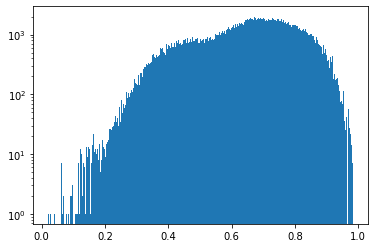

In [ ]:
lower_tri = np.tril(doc_label_dists.to_numpy(), -1).ravel()
lower_tri = lower_tri[lower_tri !=0]

# remove inf values
lower_tri = lower_tri[~np.isinf(lower_tri)]

fig, ax = plt.subplots()
_ = ax.hist(lower_tri, bins=1000)
ax.set_yscale('log')

In [ ]:
# Data from raw UAT - knowledge graph

#distarr = np.load('gdrive/MyDrive/ADS/code/glove_plus_plus/data/dist1.npz')['arr']
#labels_txt = pickle.load(open('gdrive/MyDrive/ADS/code/glove_plus_plus/data/labels1.pkl',mode='rb'))

#print(distarr.shape, len(labels_txt))

#df_uat = pd.DataFrame(distarr)
#df_uat.columns = labels_txt
#df_uat.index = labels_txt

df_uat = doc_label_dists

In [ ]:
print(df_uat.loc['Convolutional neural networks','Random Forests'], df_uat.loc['Random Forests','Convolutional neural networks'])
print(df_uat.loc['Gravitation','Random Forests'], df_uat.loc['Random Forests','Gravitation'])
#print(df_uat.values.min(),df_uat.values.max())

0.8909091362503175 0.8909091362503175
0.588889044190724 0.588889044190724


In [ ]:
df_uat.loc['Stellar kinematics','Stellar motion']


0.9260444767997942

## Load glove embeddings

In [ ]:
emmbed_dict = {}
with open('gdrive/MyDrive/Exploring Concept Extraction/embeddings/results_glove.txt','r', encoding='utf-8') as f:
#with open('gdrive/MyDrive/ADS/processed_data/results_glove_alt1.txt','r', encoding='utf-8') as f:
  for line in f:
    # print(line)
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emmbed_dict[word]=vector

print(len(emmbed_dict.keys()))
# emmbed_dict['star']

615661


In [ ]:
from glove import Corpus, Glove # creating a corpus object
gl = Glove(no_components=128, learning_rate=0.05)
# gl = gl.load('gdrive/MyDrive/ADS/processed_data/g3.vec') # SAVE_MODEL_PATHVEC)
gl = gl.load('gdrive/MyDrive/Exploring Concept Extraction/embeddings/g.vec')

In [ ]:
print(gl.most_similar('star'))
gl.most_similar('planet')

[('types', 0.749371853593767), ('formation', 0.6665085244644636), ('w2162', 0.6504713694978578), ('80182', 0.6425332678747943)]


[('exosolar', 0.851189701736992),
 ('planets', 0.8412415049091313),
 ('planetary', 0.7971649748499616),
 ('jupitermass', 0.7368981685165394)]

In [ ]:
print(gl.most_similar('star',number=10))

[('types', 0.749371853593767), ('formation', 0.6665085244644636), ('w2162', 0.6504713694978578), ('80182', 0.6425332678747943), ('companion', 0.6362736342026849), ('13283294', 0.6334574172564219), ('15757', 0.6329605807021285), ('l135', 0.6296613898174301), ('w2420', 0.6280031659736536)]


In [ ]:
print(gl.most_similar('stars',number=10))

[('binary', 0.8056221909612145), ('variable', 0.7551520273027617), ('lyrae', 0.7002916296214436), ('lowmass', 0.6930125755061449), ('hzzeroage', 0.6764590950171177), ('types', 0.6598925816192466), ('shortperiod', 0.653998217929349), ('80182', 0.6529209328107739), ('rrab', 0.6494028452212041)]


### Read labels

In [ ]:
df = pd.read_csv('gdrive/MyDrive/Exploring Concept Extraction/output/sampled_dataset1.csv')
alllabels = set(df.sorted_concepts.apply(lambda x: literal_eval(x)).sum())
print(len(alllabels))
notfound = pickle.load(open('gdrive/MyDrive/Exploring Concept Extraction/output/not_found_list.p','rb'))
alllabels = sorted(list(alllabels.difference(notfound)))
print(len(alllabels))




1922
1561


In [ ]:
alllabels_new = sorted(list(set(alllabels).intersection(set(df_uat.index))))
print(len(alllabels_new))
# #There are some labels in dataset but not in knowledge graph 
# # alllabels.difference(set(df_uat.index))
# {'Comet volatiles',
#  'Exoplanet atmospheric composition',
#  'Kreutz Sungrazers',
#  'Light curve classification',
#  'Period search',
#  'Small solar system bodies'}


1174


In [ ]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower() #.decode('utf-8')
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(emmbed_dict[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(128)
    return v / np.sqrt((v ** 2).sum())


In [ ]:
label_emb = []
for i in alllabels_new: #alllabels_processed
    label_emb.append(sent2vec(i))

label_emb_df = pd.DataFrame(label_emb).T
label_emb_df.columns = alllabels_new
print(label_emb_df.shape)
label_emb_df

(128, 1174)


,A stars,AGN host galaxies,AM Canum Venaticorum stars,AM Herculis stars,Abell clusters,Absolute magnitude,Abundance ratios,Accelerating universe,Accretion,Achondrites,...,X-ray transient sources,Y dwarfs,Young massive clusters,Young star clusters,Young stellar objects,ZZ Ceti stars,Zodiacal cloud,cD galaxies,pp waves,von Zeipel theorem
0,0.003720,-0.051386,0.059290,0.015051,-0.008049,0.050733,-0.039776,-0.144671,-0.028530,0.040506,...,-0.030096,-0.000732,-0.038875,-0.058826,-0.080829,0.011292,0.001607,-0.026793,-0.031816,-0.033538
1,0.118303,0.071887,0.070630,0.104569,0.037988,0.084363,0.123480,0.091072,0.113794,0.054348,...,0.084584,0.041811,0.102725,0.096163,0.095077,0.012408,-0.034803,0.055773,0.019285,-0.019732
2,-0.113833,-0.040911,-0.169885,-0.207300,-0.089666,0.236092,0.073905,0.045668,-0.046246,-0.068881,...,-0.054217,0.094262,-0.073481,-0.028253,-0.019418,-0.111699,0.035483,0.022396,0.060871,-0.061171
3,-0.056922,0.134115,-0.025426,-0.085746,0.073575,-0.059579,0.048343,-0.001053,-0.005683,-0.014447,...,0.001087,-0.012650,0.003286,-0.051534,-0.132145,-0.058086,-0.012167,0.156560,0.050336,0.040895
4,0.019087,-0.071756,-0.094207,-0.011102,-0.022383,0.057460,0.055343,-0.057437,0.064714,-0.123505,...,0.117536,-0.002743,-0.090737,-0.044129,-0.024968,0.120526,0.143013,-0.027865,-0.003763,-0.242710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,-0.234529,0.082714,-0.200891,-0.180601,0.100746,-0.228240,-0.014287,-0.092504,-0.077588,0.133560,...,0.004034,-0.094897,-0.027579,-0.058358,-0.019398,-0.147752,0.102555,0.026862,-0.047627,-0.074223
124,-0.005534,-0.073788,-0.009131,-0.020186,0.060977,0.124426,0.099592,0.004338,-0.048222,-0.025400,...,-0.042710,-0.034550,-0.090166,-0.072056,-0.056645,-0.058660,-0.051178,-0.036010,0.013680,0.100472
125,-0.049872,-0.118528,-0.035694,-0.067981,-0.109352,-0.086490,-0.137792,0.026648,-0.151780,-0.078635,...,-0.017201,-0.084062,-0.087825,-0.111205,-0.060068,-0.076904,-0.003644,-0.088194,-0.067944,-0.062991
126,-0.047332,0.157581,-0.152084,-0.127297,0.011866,0.052536,-0.036492,0.101297,0.037393,-0.267278,...,-0.032376,-0.010434,0.041720,0.063940,-0.048335,-0.154898,0.022697,-0.030449,-0.235978,-0.152413


In [ ]:
tmp = pd.DataFrame(label_emb_df.sum()).reset_index()
tmp.columns = ['labels','emb_sum']
tmp[tmp.emb_sum==0]

,labels,emb_sum
394,Gamma-rays,0.0
667,Non-Gaussianity,0.0
705,P-process,0.0
746,Plasmapause,0.0
782,R-process,0.0
844,S-process,0.0


In [ ]:
#Filter UAT / knowledge graph labels 

df_uat_filtered = df_uat.loc[list(alllabels_new)][list(alllabels_new)]
df_uat_filtered

,A stars,AGN host galaxies,AM Canum Venaticorum stars,AM Herculis stars,Abell clusters,Absolute magnitude,Abundance ratios,Accelerating universe,Accretion,Achondrites,...,X-ray transient sources,Y dwarfs,Young massive clusters,Young star clusters,Young stellar objects,ZZ Ceti stars,Zodiacal cloud,cD galaxies,pp waves,von Zeipel theorem
label,,,,,,,,,,,,,,,,,,,,,
A stars,1.000000,0.766530,0.521813,0.486410,0.723136,0.455840,0.790100,0.656434,0.829786,0.844796,...,0.663918,0.695317,0.521430,0.768123,0.775870,0.514520,0.623869,0.690326,0.596439,0.479179
AGN host galaxies,0.766530,1.000000,0.712840,0.677437,0.730308,0.646867,0.797271,0.663606,0.936744,0.773823,...,0.854945,0.702489,0.712458,0.775295,0.783042,0.705547,0.631041,0.697498,0.603610,0.670206
AM Canum Venaticorum stars,0.521813,0.712840,1.000000,0.816686,0.485590,0.786116,0.552554,0.418888,0.692026,0.529106,...,0.796321,0.457771,0.691830,0.530577,0.538324,0.844796,0.386323,0.452780,0.358893,0.809455
AM Herculis stars,0.486410,0.677437,0.816686,1.000000,0.450187,0.750713,0.517151,0.383485,0.656624,0.493703,...,0.760918,0.422368,0.656427,0.495174,0.502921,0.809393,0.350920,0.417377,0.323490,0.774052
Abell clusters,0.723136,0.730308,0.485590,0.450187,1.000000,0.419618,0.800764,0.820128,0.793564,0.730429,...,0.627695,0.659095,0.485208,0.893439,0.901186,0.478297,0.714197,0.854020,0.560216,0.442956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZZ Ceti stars,0.514520,0.705547,0.844796,0.809393,0.478297,0.778823,0.545261,0.411595,0.684734,0.521813,...,0.789028,0.450478,0.684537,0.523285,0.531031,1.000000,0.379030,0.445487,0.351600,0.802162
Zodiacal cloud,0.623869,0.631041,0.386323,0.350920,0.714197,0.320351,0.701497,0.647495,0.694297,0.631162,...,0.528428,0.559828,0.385941,0.759184,0.766931,0.379030,1.000000,0.681387,0.460949,0.343689
cD galaxies,0.690326,0.697498,0.452780,0.417377,0.854020,0.386807,0.767954,0.787318,0.760754,0.697619,...,0.594885,0.626285,0.452398,0.860629,0.868375,0.445487,0.681387,1.000000,0.527406,0.410146


In [ ]:
print(label_emb_df.shape)
label_emb_df.values.min(), label_emb_df.values.max()

(128, 1174)


(-0.33311229944229126, 0.3357076346874237)

In [ ]:
cosine_similarity(label_emb_df.T).min(), cosine_similarity(label_emb_df.T).max()

(-0.7379207753092136, 1.000000000000002)

In [ ]:
# 'Stellar kinematics','Stellar motion'
print(cosine_similarity([label_emb_df['Stellar kinematics'],label_emb_df['Stellar motion']])) 



[[1.         0.88301905]
 [0.88301905 1.        ]]


In [ ]:
print(cosine_similarity([label_emb_df['Convolutional neural networks'],label_emb_df['Random Forests']]))



[[1.        0.2930522]
 [0.2930522 1.       ]]


In [ ]:
print(df_uat_filtered.loc['Convolutional neural networks','Random Forests'])
df_uat_filtered.loc['Random Forests','Convolutional neural networks']

0.8909091362503175


0.8909091362503175

In [ ]:
df_uat_filtered

,A stars,AGN host galaxies,AM Canum Venaticorum stars,AM Herculis stars,Abell clusters,Absolute magnitude,Abundance ratios,Accelerating universe,Accretion,Achondrites,...,X-ray transient sources,Y dwarfs,Young massive clusters,Young star clusters,Young stellar objects,ZZ Ceti stars,Zodiacal cloud,cD galaxies,pp waves,von Zeipel theorem
label,,,,,,,,,,,,,,,,,,,,,
A stars,1.000000,0.766530,0.521813,0.486410,0.723136,0.455840,0.790100,0.656434,0.829786,0.844796,...,0.663918,0.695317,0.521430,0.768123,0.775870,0.514520,0.623869,0.690326,0.596439,0.479179
AGN host galaxies,0.766530,1.000000,0.712840,0.677437,0.730308,0.646867,0.797271,0.663606,0.936744,0.773823,...,0.854945,0.702489,0.712458,0.775295,0.783042,0.705547,0.631041,0.697498,0.603610,0.670206
AM Canum Venaticorum stars,0.521813,0.712840,1.000000,0.816686,0.485590,0.786116,0.552554,0.418888,0.692026,0.529106,...,0.796321,0.457771,0.691830,0.530577,0.538324,0.844796,0.386323,0.452780,0.358893,0.809455
AM Herculis stars,0.486410,0.677437,0.816686,1.000000,0.450187,0.750713,0.517151,0.383485,0.656624,0.493703,...,0.760918,0.422368,0.656427,0.495174,0.502921,0.809393,0.350920,0.417377,0.323490,0.774052
Abell clusters,0.723136,0.730308,0.485590,0.450187,1.000000,0.419618,0.800764,0.820128,0.793564,0.730429,...,0.627695,0.659095,0.485208,0.893439,0.901186,0.478297,0.714197,0.854020,0.560216,0.442956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZZ Ceti stars,0.514520,0.705547,0.844796,0.809393,0.478297,0.778823,0.545261,0.411595,0.684734,0.521813,...,0.789028,0.450478,0.684537,0.523285,0.531031,1.000000,0.379030,0.445487,0.351600,0.802162
Zodiacal cloud,0.623869,0.631041,0.386323,0.350920,0.714197,0.320351,0.701497,0.647495,0.694297,0.631162,...,0.528428,0.559828,0.385941,0.759184,0.766931,0.379030,1.000000,0.681387,0.460949,0.343689
cD galaxies,0.690326,0.697498,0.452780,0.417377,0.854020,0.386807,0.767954,0.787318,0.760754,0.697619,...,0.594885,0.626285,0.452398,0.860629,0.868375,0.445487,0.681387,1.000000,0.527406,0.410146


In [ ]:
#arr = df_uat_filtered.values
#sc = MinMaxScaler((0,1))
#sc.fit(arr.flatten().reshape(-1,1))
#arr = sc.transform(arr.flatten().reshape(-1,1)).reshape(df_uat_filtered.shape)
# back to dataframe
#df_uat_scaled = pd.DataFrame(arr, columns = df_uat_filtered.columns, index=df_uat_filtered.index)

# no need to scale anymore, just rename for compatibility
df_uat_scaled = df_uat_filtered

In [ ]:
df_uat_scaled.loc['Convolutional neural networks','Random Forests'], df_uat_scaled.loc['Random Forests','Convolutional neural networks']

(0.8909091362503175, 0.8909091362503175)

In [ ]:
df_uat_scaled

,A stars,AGN host galaxies,AM Canum Venaticorum stars,AM Herculis stars,Abell clusters,Absolute magnitude,Abundance ratios,Accelerating universe,Accretion,Achondrites,...,X-ray transient sources,Y dwarfs,Young massive clusters,Young star clusters,Young stellar objects,ZZ Ceti stars,Zodiacal cloud,cD galaxies,pp waves,von Zeipel theorem
label,,,,,,,,,,,,,,,,,,,,,
A stars,1.000000,0.766530,0.521813,0.486410,0.723136,0.455840,0.790100,0.656434,0.829786,0.844796,...,0.663918,0.695317,0.521430,0.768123,0.775870,0.514520,0.623869,0.690326,0.596439,0.479179
AGN host galaxies,0.766530,1.000000,0.712840,0.677437,0.730308,0.646867,0.797271,0.663606,0.936744,0.773823,...,0.854945,0.702489,0.712458,0.775295,0.783042,0.705547,0.631041,0.697498,0.603610,0.670206
AM Canum Venaticorum stars,0.521813,0.712840,1.000000,0.816686,0.485590,0.786116,0.552554,0.418888,0.692026,0.529106,...,0.796321,0.457771,0.691830,0.530577,0.538324,0.844796,0.386323,0.452780,0.358893,0.809455
AM Herculis stars,0.486410,0.677437,0.816686,1.000000,0.450187,0.750713,0.517151,0.383485,0.656624,0.493703,...,0.760918,0.422368,0.656427,0.495174,0.502921,0.809393,0.350920,0.417377,0.323490,0.774052
Abell clusters,0.723136,0.730308,0.485590,0.450187,1.000000,0.419618,0.800764,0.820128,0.793564,0.730429,...,0.627695,0.659095,0.485208,0.893439,0.901186,0.478297,0.714197,0.854020,0.560216,0.442956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZZ Ceti stars,0.514520,0.705547,0.844796,0.809393,0.478297,0.778823,0.545261,0.411595,0.684734,0.521813,...,0.789028,0.450478,0.684537,0.523285,0.531031,1.000000,0.379030,0.445487,0.351600,0.802162
Zodiacal cloud,0.623869,0.631041,0.386323,0.350920,0.714197,0.320351,0.701497,0.647495,0.694297,0.631162,...,0.528428,0.559828,0.385941,0.759184,0.766931,0.379030,1.000000,0.681387,0.460949,0.343689
cD galaxies,0.690326,0.697498,0.452780,0.417377,0.854020,0.386807,0.767954,0.787318,0.760754,0.697619,...,0.594885,0.626285,0.452398,0.860629,0.868375,0.445487,0.681387,1.000000,0.527406,0.410146


In [ ]:
idx2label = {k: v for k,v in enumerate(df_uat_scaled.columns)}

label2idx = {v: k for k,v in enumerate(df_uat_scaled.columns)}


## Create Pytorch dataset 

In [ ]:
class GDataset:
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # print(self.data.index)
        lnames = self.data.index[idx] 
        # print(torch.tensor(lnames))
        return {
            'glove_emb' : torch.tensor(self.data.values[idx],dtype=torch.float32,device='cuda:0'), 
            'label_idx': torch.tensor(label2idx[lnames],device='cuda:0'),
            'target' : torch.tensor(self.targets.loc[lnames,lnames], dtype=torch.float32,device='cuda:0')
        }

gdt = GDataset(label_emb_df.T,df_uat_scaled)

In [ ]:
# gdt[0]['glove_emb'].shape #128
# gdt[0]['target']
gdt[0]

{'glove_emb': tensor([ 0.0037,  0.1183, -0.1138, -0.0569,  0.0191,  0.0044,  0.0520, -0.0426,
         -0.0102,  0.0618,  0.0226, -0.0572,  0.0078, -0.0113, -0.0462, -0.0163,
         -0.0833,  0.0177,  0.0772, -0.0128, -0.0911, -0.1439, -0.0960,  0.0409,
          0.1321, -0.0091,  0.0558,  0.0433,  0.0931, -0.1041, -0.0288, -0.1511,
         -0.0172,  0.1091,  0.1138,  0.0193,  0.0149,  0.1708,  0.0572,  0.0542,
         -0.2150, -0.0174, -0.0782,  0.0695,  0.0696, -0.1290, -0.0213,  0.0380,
          0.0176,  0.0350,  0.1114, -0.0583, -0.0377, -0.1276,  0.0534,  0.1259,
         -0.0397, -0.2007,  0.0194, -0.1183,  0.0053, -0.1528, -0.1047, -0.0533,
         -0.1703,  0.0279,  0.0510, -0.0930, -0.0326, -0.1037, -0.0309,  0.0833,
          0.0105,  0.0552,  0.1817, -0.1193, -0.0483, -0.1157, -0.1524,  0.0122,
         -0.1072, -0.0517,  0.1301, -0.0342,  0.0040,  0.1484,  0.0500, -0.0476,
          0.0894, -0.0426,  0.0392,  0.0880, -0.1781,  0.1093,  0.0273, -0.1517,
          0.009

## Model

In [ ]:
class GModel(tez.Model):
    def __init__(self, n_features, target_data):
        super().__init__()
        self.target_data = target_data
        # You can play with the layers and create awesome models
        self.layer_1 = nn.Sequential(         
              nn.Linear(n_features, n_features//2),
              nn.GELU(),
              nn.Linear(n_features//2, n_features) )

        self.step_scheduler_after = "epoch"
        
    # def monitor_metrics(self, outputs, targets):
    #     if targets is None:
    #         return {}
    #     outputs = outputs.cpu().detach().numpy()
    #     targets = targets.cpu().detach().numpy()
    #     roc_auc = metrics.roc_auc_score(targets, outputs)
    #     return {"AUC": roc_auc
    #            }
    
    def fetch_optimizer(self):
        opt = torch.optim.Adam(self.parameters(), lr=1e-4)
        return opt
    
    def fetch_scheduler(self):
        sch = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer, T_0=10, T_mult=1, eta_min=1e-5, last_epoch=-1
        )
        return sch

    def forward(self, glove_emb, label_idx=None, target=None):
        outputs = self.layer_1(glove_emb)
        
        lnames = [idx2label[i.item()] for i in label_idx]
        
        target_d = torch.tensor(self.target_data.loc[lnames,lnames].values, device='cuda:0')

        if target is not None:
            #loss = torch.mean(((1 - pymcosinesim()(outputs,outputs))/2.0 - target_d)**2)
            loss = torch.mean(((1 - (outputs/torch.linalg.norm(outputs, dim=1).view(-1,1))
                .matmul((outputs/torch.linalg.norm(outputs, dim=1).view(-1,1)).transpose(0,1)))/2.0 - target_d)**2)
            
            metrics = {'metrics':loss.item()} 
            return outputs, loss , metrics
        return outputs, None, None

In [ ]:
#m = GModel(128, target_data=df_uat_scaled)
#gemb = torch.tensor(np.stack([gdt[0]['glove_emb'],gdt[1]['glove_emb']]))
#target = torch.tensor(np.stack([gdt[0]['target'],gdt[1]['target']]))
#lnames = np.stack([gdt[0]['label_idx'],gdt[1]['label_idx']])
#output = m(gemb,lnames, target)

In [ ]:
# output

In [ ]:
m = GModel(128,target_data=df_uat_scaled)

In [ ]:
train_gdt = GDataset(label_emb_df.T.iloc[0:1405,:],df_uat_scaled.iloc[0:1405,0:1405])
val_gdt = GDataset(label_emb_df.T.iloc[1405:,:],df_uat_scaled.iloc[1405:,1405:])

In [ ]:
# gdt = GDataset(label_emb_df.T,df_uat_scaled)
m.fit(train_gdt,valid_dataset=val_gdt, train_bs=512,valid_bs=64,device='cuda:0',epochs=200,n_jobs=0)

100%|██████████| 3/3 [00:00<00:00,  8.09it/s, epoch=399, loss=nan, metrics=nan, stage=train]


In [ ]:
gdt = GDataset(label_emb_df.T,df_uat_scaled)
output = m.predict(gdt,n_jobs=0)

In [ ]:
preds = []
for p in output:
  preds.append(p)
print(len(preds))
allpreds = np.vstack(preds)
print(allpreds.shape)

  0%|          | 0/74 [00:00<?, ?it/s]


RuntimeError: ignored

In [ ]:
allpreds_df = pd.DataFrame(allpreds,index=label_emb_df.T.index).T
allpreds_df

,A dwarf stars,A giant stars,A stars,A subgiant stars,A supergiant stars,AGN host galaxies,AM Canum Venaticorum stars,AM Herculis stars,Abell clusters,Absolute magnitude,Abundance ratios,Accelerating universe,Accretion,Achondrites,Active galactic nuclei,Active galaxies,Active solar chromosphere,Active solar corona,Active sun,Ae stars,Aeronomy,Akaike information criterion,Alfven waves,Algol variable stars,Algorithms,All-sky cameras,Am stars,Amateur astronomers,Amateur astronomy,Amor group,Amorphous irregular galaxies,Analytical mathematics,Andromeda Galaxy,Angular separation,Annual parallax,Anomalous Cepheid variable stars,Antarctic observatories,Ap stars,Aperiodic comets,Aperture synthesis,...,Warm-hot intergalactic medium,Water masers,Water vapor,Wavelet analysis,Weak gravitational lensing,Weak-line T Tauri stars,White dwarf stars,Wide binary stars,Wide-field telescopes,Wolf-Rayet stars,X-ray active galactic nuclei,X-ray astronomy,X-ray binary stars,X-ray bright point,X-ray bursters,X-ray bursts,X-ray detectors,X-ray identification,X-ray novae,X-ray observatories,X-ray photometry,X-ray point sources,X-ray quasars,X-ray sources,X-ray stars,X-ray surveys,X-ray telescopes,X-ray transient sources,Xallarap effect,Y dwarfs,Young disk Cepheid variable stars,Young massive clusters,Young star clusters,Young stellar objects,ZZ Ceti stars,Zero-age main sequence stars,Zodiacal cloud,cD galaxies,pp waves,von Zeipel theorem
0,-0.012382,-0.031163,-0.046067,-0.037229,-0.042524,0.026687,-0.044888,-0.059938,0.004376,0.037129,0.035750,-0.033969,0.030107,0.010126,-0.017976,-0.002786,-0.019792,-0.019119,-0.042162,-0.028043,0.045702,0.013098,0.035750,-0.024845,0.024172,-0.006970,-0.046067,-0.021699,-0.033020,0.017074,0.015437,0.009831,0.019101,0.020967,0.017613,-0.007591,-0.026032,-0.029132,-0.022871,0.001763,...,-0.036812,0.035231,0.038098,0.058516,0.056214,-0.011272,-0.000337,-0.059843,0.056307,-0.046067,-0.017976,-0.040701,-0.052989,0.052106,0.000068,0.018956,0.022701,0.006861,0.017659,-0.031783,0.027375,0.039055,0.008349,0.003509,-0.046067,-0.000314,0.056307,0.007649,0.028210,-0.053340,-0.010787,-0.033341,-0.029577,-0.065822,-0.054915,-0.022178,0.023577,0.047510,-0.003646,-0.030790
1,0.051373,0.039485,0.014273,0.041629,0.035510,0.006487,-0.015098,0.025652,0.026892,0.009400,0.012540,-0.045561,-0.024423,-0.019891,-0.019646,0.023398,0.002867,0.012836,-0.022103,0.037569,-0.053576,0.014913,-0.012153,0.033271,-0.034653,-0.019770,0.014273,-0.074117,-0.059120,-0.005873,0.071886,-0.066656,-0.011392,-0.025913,-0.000272,0.041575,-0.065269,0.030735,0.047200,-0.015980,...,-0.026379,0.015128,-0.025503,0.041383,-0.074019,0.010357,0.053279,-0.026727,-0.012289,0.014273,-0.019646,-0.045957,-0.021859,0.067784,-0.000395,0.010663,-0.149473,0.013218,0.026297,-0.059250,0.014038,0.067497,-0.023818,0.048290,0.014273,-0.061796,-0.012289,0.021563,0.004051,0.040366,0.046575,0.012819,0.015330,0.052414,0.029310,0.017775,0.045894,0.065259,-0.005563,-0.035514
2,0.010539,0.021825,0.043964,0.037487,0.047569,-0.004033,-0.004822,0.025984,-0.034245,0.012541,-0.034359,-0.005470,0.002142,-0.009244,-0.004333,-0.003973,0.039439,0.043211,0.048556,0.024590,-0.014746,0.067281,-0.014039,0.047527,0.056528,-0.050289,0.043964,0.025396,0.031733,0.026039,-0.022965,0.004042,0.023943,0.035239,0.028075,0.022305,0.000403,0.018522,-0.017422,0.001123,...,-0.036979,-0.021412,-0.027884,0.004129,-0.019537,0.040085,0.030337,0.034756,-0.006269,0.043964,-0.004333,0.026716,0.037335,0.007842,-0.041659,0.002561,-0.039647,-0.017519,-0.010063,0.000582,-0.006660,0.011561,0.028262,0.014331,0.043964,0.025985,-0.006269,0.025471,-0.010311,0.023859,0.015598,-0.026039,-0.029706,-0.013813,0.017202,0.028595,-0.051412,-0.032074,-0.024723,0.021395
3,0.048037,0.031791,0.060445,0.042146,0.046531,0.014014,0.065644,0.067673,-0.002729,0.007363,0.006326,-0.011512,-0.001406,0.017872,0.027541,0.020159,0.018298,0.023705,0.034483,0.023918,0.010332,0.002611,-0.001586,0.052814,-0.014683,0.026938,0.060445,0.079826,0.049073,0.013629,

In [ ]:

print(cosine_similarity([allpreds_df['Stellar kinematics'],allpreds_df['Stellar motion']])) #'A stars']])) #


[[0.9999999  0.73336756]
 [0.73336756 0.9999998 ]]


In [ ]:
print(cosine_similarity([allpreds_df['Convolutional neural networks'],allpreds_df['Random Forests']])) #'A stars']])) #


[[1.0000001  0.36085823]
 [0.36085823 1.        ]]


In [ ]:
allpreds_df.to_csv('allpreds_df_alt1.csv',index=False)

In [ ]:
!cp allpreds_df_alt1.csv gdrive/MyDrive/ADS/code/glove_plus_plus/

## END

In [ ]:
for i in alllabels_new:
  if 'survey' in i: 
    print(i)

Redshift surveys
Sky surveys
Ultraviolet surveys
X-ray surveys


In [ ]:
label_int =  'Redshift surveys' #'Circumstellar disks'

df_uat_filtered[[label_int]].sort_values(label_int, ascending = True).head(20)

tmp_cos_df = pd.DataFrame(cosine_similarity(label_emb_df.T),columns=label_emb_df.columns,index=label_emb_df.columns)
tmp_cos_df[[label_int]].sort_values(label_int, ascending = False).head(20)

tmp_cos_pred = pd.DataFrame(cosine_similarity(allpreds_df.T),columns=allpreds_df.columns,index=allpreds_df.columns)
tmp_cos_pred = tmp_cos_pred[[label_int]].sort_values(label_int, ascending = False).head(20)

combinedf = pd.DataFrame(tmp_cos_pred).reset_index()
combinedf.columns = ['glove++','preds_df']
combinedf['UAT'] = df_uat_filtered[[label_int]].sort_values(label_int, ascending = True).head(20).index
combinedf['original glove(alt)'] =  tmp_cos_df[[label_int]].sort_values(label_int, ascending = False).head(20).index
combinedf


,glove++,preds_df,UAT,original glove(alt)
0,Redshift surveys,1.000000,Redshift surveys,Redshift surveys
1,Surveys,0.888484,Surveys,X-ray surveys
2,X-ray surveys,0.888484,X-ray surveys,Surveys
3,Redshifted,0.795212,Ultraviolet surveys,Sky surveys
4,Sky surveys,0.750813,Galaxy counts,Ultraviolet surveys
5,Reionization,0.637890,Radio source counts,Redshifted
6,Ultraviolet surveys,0.628144,Star counts,Galaxy spectroscopy
7,Search for extraterrestrial intelligence,0.603248,Astronomical reference materials,High resolution spectroscopy
8,Transmission spectroscopy,0.586909,Catalogs,Galaxy classification systems
9,Transient detection,0.586461,Ephemerides,Direct imaging


In [ ]:
# With old distances 
label_int = 'Circumstellar disks'

df_uat_filtered[[label_int]].sort_values(label_int, ascending = True).head(20)

tmp_cos_df = pd.DataFrame(cosine_similarity(label_emb_df.T),columns=label_emb_df.columns,index=label_emb_df.columns)
tmp_cos_df[[label_int]].sort_values(label_int, ascending = False).head(20)

tmp_cos_pred = pd.DataFrame(cosine_similarity(allpreds_df.T),columns=allpreds_df.columns,index=allpreds_df.columns)
tmp_cos_pred = tmp_cos_pred[[label_int]].sort_values(label_int, ascending = False).head(20)

combinedf = pd.DataFrame(tmp_cos_pred).reset_index()
combinedf.columns = ['glove++','preds_df']
combinedf['UAT'] = df_uat_filtered[[label_int]].sort_values(label_int, ascending = True).head(20).index
combinedf['original glove(alt)'] =  tmp_cos_df[[label_int]].sort_values(label_int, ascending = False).head(20).index
combinedf


,glove++,preds_df,UAT,original glove(alt)
0,Circumstellar disks,1.000000,Circumstellar disks,Circumstellar disks
1,Protoplanetary disks,0.894544,Circumstellar matter,Protoplanetary disks
2,Debris disks,0.820526,Debris disks,Debris disks
3,Circumstellar dust,0.782685,Circumstellar masers,Circumstellar envelopes
4,Circumstellar envelopes,0.780980,Circumstellar grains,Circumstellar dust
5,Circumstellar gas,0.762422,Circumstellar gas,Stellar accretion disks
6,Stellar accretion disks,0.686787,Circumstellar envelopes,Circumstellar gas
7,Circumstellar grains,0.684837,Circumstellar shells,Galaxy accretion disks
8,Circumstellar shells,0.682606,Circumstellar dust,Relativistic disks
9,Gaseous nebulae,0.634961,Stellar astronomy,Circumstellar shells


In [ ]:
loss = ((1-cosine_similarity)/2 - uatdist)^2 

In [ ]:
input1 = torch.randn(3, 128)
input2 = torch.randn(3, 128)
output = torch.nn.functional.cosine_similarity(input1, input2,dim=1)
print(output.shape)
print(output)

torch.Size([3])
tensor([ 0.1654, -0.0657, -0.1226])
